# Lab 4: Comparison of Classifiers

### Student: Garret Molloy
### Student Id: 9012906

This notebook demonstrates how to choose the best out of a few alternative classification models by applying cross-validation and comparing the accuracy of prediction, the F1-scores and the ROC curves of the classification models.

Here we use a _modified version_ of the __seeds data set__ (see https://archive.ics.uci.edu/ml/datasets/seeds), which is one of the public UCI data sets. Each example is a seed described by a few numerical attributes. The target variable for classification (in this example) is the type of the seed, which can be either 1 or 0. Class 1 are the seeds of a particular type that, we can assume, is important to learn to predict correctly, while class 0 are all other seeds.

In this example, we use 5-fold cross-validation. Empirical evidence suggests that 10 folds are probably the best choice for cross-validation, i.e. 10-fold cross-validation. However, since this data set is relatively small, and 1/10 of it is only 21 examples, it is sensible to use larger folds for testing. Thus, we demonstrate the comparison of classifiers with 5-fold cross-validation.

The code in this notebook was originally inspired by the example at https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html.

## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.fixes import signature

from scipy import interp

### Import evaluation and plotting functions

In [2]:
%run ./Lab4_Functions.ipynb

# I edited this set of methods by adding a Class to return the various scores.
# Small saving in code.

### Load and prepare the dataset for training and evaluating a classifier
Feel free to apply any other pre-processing technique at this point.

In [3]:
lab4_df = pd.read_csv("./loans_et4.csv")
lab4_df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.797917,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [4]:
lab4_df.shape

(480, 12)

In [5]:
lab4_df['Loan_Status'].head(5)

0    0
1    0
2    0
3    0
4    0
Name: Loan_Status, dtype: int64

In [6]:
lab4_df['Loan_Status'].tail(5)

475    1
476    1
477    1
478    1
479    1
Name: Loan_Status, dtype: int64

I'd like to Shuffle the data so that the Loan_Status is mixed better in the sample and not at the start with all '0's and the end with all '1's.

In [7]:
# Shuffle Dataframe
lab4_df = lab4_df.sample(frac=1, random_state=8).reset_index(drop=True)

In [8]:
lab4_df['Loan_Status'].head(5)

0    1
1    1
2    0
3    1
4    1
Name: Loan_Status, dtype: int64

In [9]:
# target attribute
target = lab4_df['Loan_Status']

# predictor attributes
predictors = lab4_df.drop('Loan_Status', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### Prepare an array of 100 equally spaced false-positive-rate values between 0 and 1
To be used as an x-axis in ROC curve plots.

In [10]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

## B. Evaluation and Comparison of Classifiers

### Train a Probablistic SVM Classifier

In [11]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True, gamma='auto')

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
SVM_scores = evaluate_classifier(folds=10, 
                                p=predictors, t=target, 
                                classifier=SVM_classifier, 
                                mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

In [12]:
SVM_classifier

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

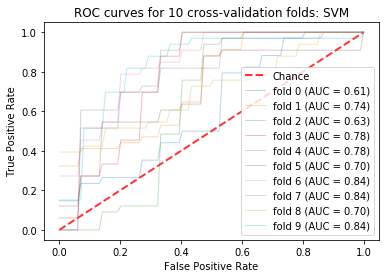

In [13]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, SVM_scores, 'SVM')

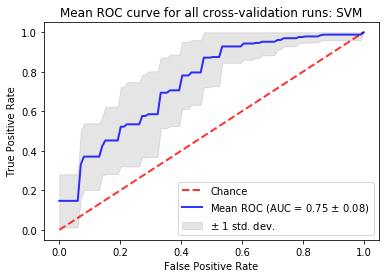

In [14]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, SVM_scores, 'SVM')

### Train a Naive Bayes Classifier

In [15]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
NB_scores = evaluate_classifier(folds=10, 
                                p=predictors, t=target, 
                                classifier=NB_classifier, 
                                mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

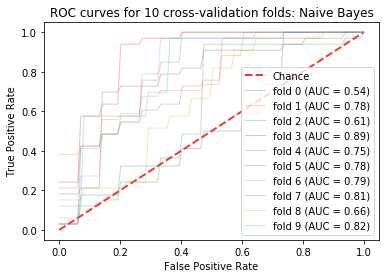

In [16]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, NB_scores, 'Naive Bayes')

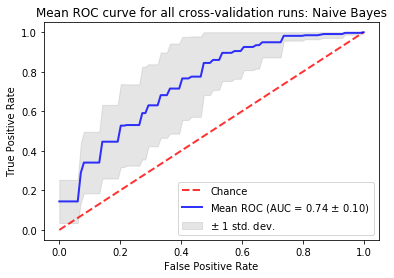

In [17]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, NB_scores, 'Naive Bayes')

### Train a NN Classifier

In [18]:
# Create a NN classifier object with default parameters 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

NN_classifier = MLPClassifier(alpha=1, random_state=0, max_iter=500, solver='sgd', 
                              learning_rate='invscaling', momentum=.9,
                              nesterovs_momentum=False, learning_rate_init=0.2)

# Train and evaluate the classifier by applying 10-fold cross validation.
# We use 5 folds only, because the data set is rather small.
NN_scores = evaluate_classifier(folds=10, 
                                p=predictors, t=target, 
                                classifier=NN_classifier, 
                                mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold

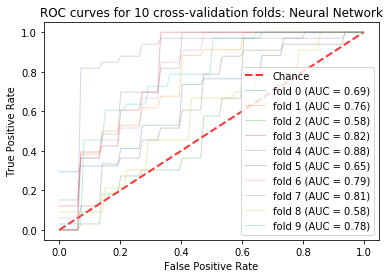

In [19]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, NN_scores, 'Neural Network')

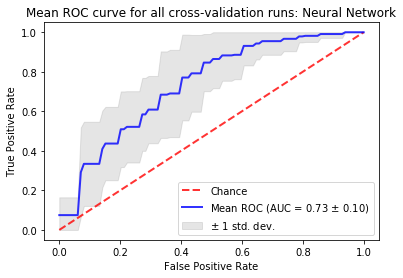

In [20]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, NN_scores, 'Neural Network')

Looking at the Mean ROC curves, and rhe AUC scores. Neural Network had the lowest scre. Perhaps there were too few samples for it to converge.

The Naive Bayes Classifier was pipped by the SVM Classifer (AUC 0.7 to AUC 0.72), not much in it.

__Note:__  I added a shuffle routine to my dataset at the start, after reading the file, as I was concerned that the data was not homogenous, that all classificaitons were ordered withthe start of the data all '0's for Loan_Status and the end al '1's.

After shuffling the data, the results for the classifiers got much better (0.74 & 0.74 for SVM and Naive Bayes respectively, up from 0.72 and 0.7 respectively).

The Neural Network also improved frmo 0.68 to 0.72!

So SVM a slight Lead in Area under the Curve, but nothing in it.


## Task 2.1
2.1 Modify the code in both Lab 4 - Comparison of Classifiers.ipynb and Lab4_Functions.ipynb to __boxplot precision and recall__ for the classifiers trained with loans_et4.csv. 

In [21]:
SVM_scores.precision_scores.shape

(10,)

In [22]:
# Compare the statistics of the accuracies across all cross-validation folds
precisions_df = pd.DataFrame(data={'SVM' : SVM_scores.precision_scores, 
                                   'Naive Bayes' : NB_scores.precision_scores, 
                                   'Neural Network' : NN_scores.precision_scores})

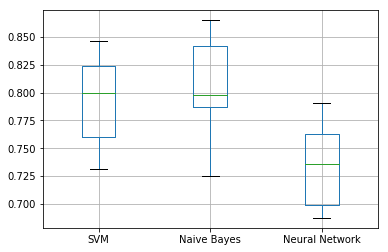

In [23]:
precisions_df.boxplot()

Looking ahead to Task 3 - where it states that "that it is important to __minimise the false positives__".
Given this requirement, precision is the most important metric.

Precision =   TP   / ( TP + FP) 

So the more false positives, the lower the precision score.

Therefore Naive Bayes has a higher range, but SVM has a slightly higher mean.


In [24]:
# Compare the statistics of the accuracies across all cross-validation folds
recall_df = pd.DataFrame(data={'SVM' : SVM_scores.recall_scores, 
                                   'Naive Bayes' : NB_scores.recall_scores, 
                                   'Neural Network' : NN_scores.recall_scores})

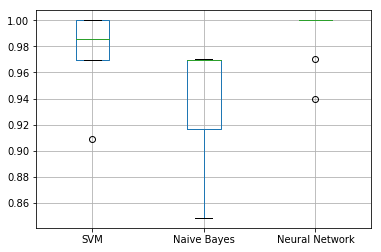

In [25]:
recall_df.boxplot()

Recall is to see how many of the True Positives versus the ones I missed, so it ignores False Negatives and is not a score pertient for the given seletion criteria.

The Boxplotsdo show the NN and the SVM clearly wee better at getting the True Positives, with NB less so.

The NN beinf clos to 1 (overfitting?)

## Task 2.2 
Plot __precision-recall curves__ for each of the trained classifiers as well. These should be the mean curves over all cross-validation runs. Update your conclusions from Task 1 after evaluating precision and recall.

In [26]:
NN_scores.precisions[0]

0.7391304347826086

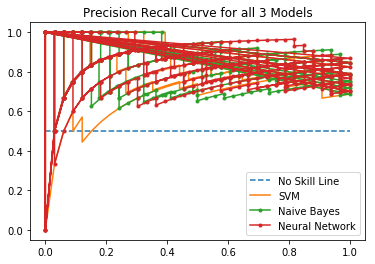

In [27]:
SVM_precision = SVM_scores.precisions
SVM_recall = SVM_scores.recalls
NB_precision = NB_scores.precisions
NB_recall = NB_scores.recalls
NN_precision = NN_scores.precisions
NN_recall = NN_scores.recalls

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--', label="No Skill Line")
# plot the roc curve for the model
plt.plot(SVM_recall, SVM_precision, label="SVM")
plt.plot(NB_recall, NB_precision, marker='.', label="Naive Bayes")
plt.plot(NN_recall, NN_precision, marker='.', label="Neural Network")
# show the plot
plt.title("Precision Recall Curve for all 3 Models")
plt.legend()
plt.show()

After reviewing the boxpots, we can see the precision of the NN is very low but the SVM and Naive Bayes are better, with the NB being slightly better.

The Recall boxplots show both the NN and SVM are best with the Naive Bayes not as good.

So for best precision and recall the SVM is the selected classifer.


### Compare All Trained Classifiers

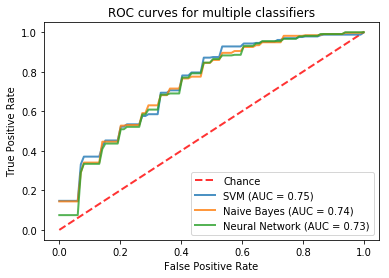

In [28]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(SVM_scores.tprs, axis=0), np.mean(NB_scores.tprs, axis=0), 
                                        np.mean(NN_scores.tprs, axis=0))), 
                              np.array([np.mean(SVM_scores.aucs), np.mean(NB_scores.aucs), np.mean(NN_scores.aucs)]), 
                              np.array(['SVM', 'Naive Bayes', 'Neural Network']))

In [29]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : SVM_scores.accuracies, 'Naive Bayes' : NB_scores.accuracies, 'Neural Network' : NN_scores.accuracies})

In [30]:
accuracies_df.describe()

,SVM,Naive Bayes,Neural Network
count,10.000000,10.000000,10.000000
mean,0.808340,0.796141,0.743579
std,0.056208,0.063590,0.046779
min,0.708333,0.673469,0.687500
25%,0.769452,0.755208,0.697917
50%,0.814413,0.793793,0.744681
75%,0.848072,0.854167,0.782526
max,0.875000,0.872340,0.816327


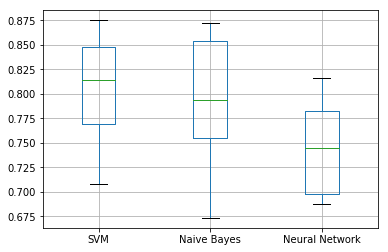

In [31]:
accuracies_df.boxplot()

In [32]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : SVM_scores.f1_scores, 'Naive Bayes' : NB_scores.f1_scores, 'Neural Network' : NN_scores.f1_scores})

In [33]:
f1_scores_df.describe()

,SVM,Naive Bayes,Neural Network
count,10.000000,10.000000,10.000000
mean,0.876599,0.864253,0.842953
std,0.033900,0.041719,0.024903
min,0.810811,0.783784,0.814815
25%,0.853793,0.842847,0.817778
50%,0.879915,0.864766,0.846154
75%,0.900304,0.901408,0.862854
max,0.916667,0.914286,0.883117


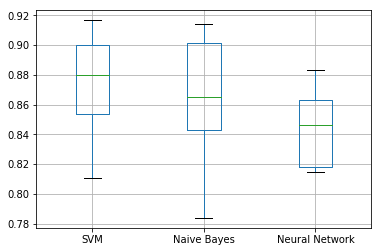

In [34]:
f1_scores_df.boxplot()

## Task 3.1 (CS5062)

__Pick a winner among the classifiers__ you have trained with loans_et4.csv. Assume that it is important to __minimise the false positives__ (i.e., Loan_Status predicted to be 1 wrongly). 

#### Conclusion

SVM is the better classifer in both accuracy, recall & f1 Scores, SVM and NB as neck and neck on AUC.

However the Key criterai from Task 3 was to reduce the False Positives as a priority, then I must pput extra weight on the Presicion Score.

However SVM and Naive Bayes were very close on this with SVM having a higher MEan score on this.


## Task 3.2 (CS5062)
Look up the training parameters for this classifier on the scikit-learn website. For example, SVM has more than 10 parameters (see https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). 

__Experiment with the parameters and see if you can improve the model in terms of accuracy, precision, recall and AUC.__ 

You do not have to build a better model but to show that you have explored some of its training parameters. Summarise your experience with exploring the parameters (max 150 words in a markdown cell).

In [35]:
SVM_classifier

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

The SVM Classifier has the parameters shown above:

Original SVM Instantiated was:

    SVM_classifier = svm.SVC(probability=True, gamma='auto')

In [36]:
lab4_df['Loan_Status'].value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

In [37]:
(148)/(332+148)

0.30833333333333335

In [38]:
SVM_classifier = svm.SVC(probability=True, gamma='auto')

SVM_classifier2 = svm.SVC(kernel='linear', probability=True, gamma='auto', random_state=5)

SVM_classifier3 = svm.SVC(kernel='poly', probability=True, gamma='auto', coef0=0.4, random_state=5)

SVM_classifier4 = svm.SVC(kernel='sigmoid', 
                          decision_function_shape='ovo', coef0=0.3,
                          probability=True, gamma='scale', random_state=5)

SVM_scores2 = evaluate_classifier(folds=10, 
                                p=predictors, t=target, 
                                classifier=SVM_classifier2, 
                                mean_fpr=mean_fpr)
SVM_scores3 = evaluate_classifier(folds=10, 
                                p=predictors, t=target, 
                                classifier=SVM_classifier3, 
                                mean_fpr=mean_fpr)
SVM_scores4 = evaluate_classifier(folds=10, 
                                p=predictors, t=target, 
                                classifier=SVM_classifier4, 
                                mean_fpr=mean_fpr)


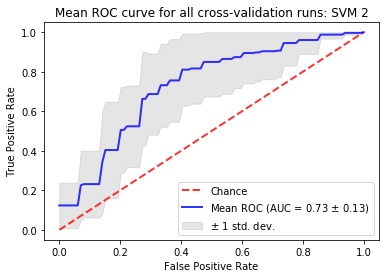

In [39]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, SVM_scores2, 'SVM 2')

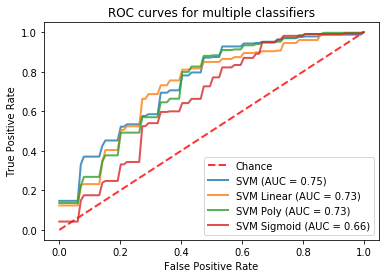

In [40]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(SVM_scores.tprs, axis=0), 
                                        np.mean(SVM_scores2.tprs, axis=0), 
                                        np.mean(SVM_scores3.tprs, axis=0), 
                                        np.mean(SVM_scores4.tprs, axis=0))), 
                              np.array([np.mean(SVM_scores.aucs), 
                                        np.mean(SVM_scores2.aucs), 
                                        np.mean(SVM_scores3.aucs), 
                                        np.mean(SVM_scores4.aucs)]), 
                              np.array(['SVM', 'SVM Linear', 'SVM Poly', 'SVM Sigmoid']))

In [41]:
accuracies_df2 = pd.DataFrame(data={'SVM' : SVM_scores.accuracies, 
                                   'SVM linear' : SVM_scores2.accuracies,
                                   'SVM poly' : SVM_scores3.accuracies,
                                   'SVM sigmoid' : SVM_scores4.accuracies,
                                   'Naive Bayes' : NB_scores.accuracies,
                                   'Neural Network' : NN_scores.accuracies})

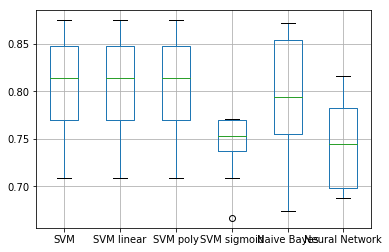

In [42]:
accuracies_df2.boxplot()

In [43]:
precisions_df2 = pd.DataFrame(data={'SVM' : SVM_scores.precision_scores, 
                                   'SVM linear' : SVM_scores2.precision_scores, 
                                   'SVM poly' : SVM_scores3.precision_scores, 
                                   'SVM sigmoid' : SVM_scores4.precision_scores, 
                                   'Naive Bayes' : NB_scores.precision_scores, 
                                   'Neural Network' : NN_scores.precision_scores})

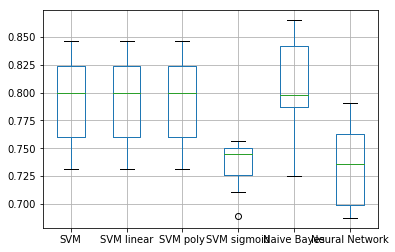

In [44]:
precisions_df2.boxplot()

In [45]:
recall_df2 = pd.DataFrame(data={'SVM' : SVM_scores.recall_scores, 
                                   'SVM linear' : SVM_scores2.recall_scores, 
                                   'SVM poly' : SVM_scores3.recall_scores, 
                                   'SVM sigmoid' : SVM_scores4.recall_scores,                                    'Naive Bayes' : NB_scores.recall_scores, 
                                   'Naive Bayes' : NB_scores.recall_scores, 
                                   'Neural Network' : NN_scores.recall_scores})

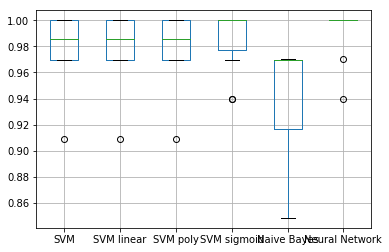

In [46]:
recall_df2.boxplot()

### Tuning Parmeters fo SVM

__kernel__ 
No change to precision or accuracy except for Kernel = poly which has very poor scores, however in conjuction with setting kernel to 'poly' I updated coef0 to 0.1 and this resolved the poor scores.

__coef0__
Set to 0 by default, with 'poly' we had poor scoresm which imporved when set to 0.1.
Adding it to 'sigmoid' made it improve the sigmoid scores back to parity.
I will try other values.

__gamma__
Adding gamma='scaled'  worsened the accuracy and precision slightly.

__decision_function__
decision_function_shape='ovo' did not chaneg the scoring

Final Values for sigmoid kernel saw reduced accuracy and precision but  improved mean recall.

